# ezData: A simplistic column based data framework.

>
>    * requirements: numpy, matplotlib
>    * conversion to other formats require the appropriate library.
>    * some additional wrappers around bokeh, plotly and holoviews are in dev.
>

Documentation and API: [link](http://mfouesneau.github.io/docs/ezdata/)

## Why?

I always found myself writing snippets around `numpy`, `matplotlib`, pandas and
other file readers. These are often the same things: read file `foo` and plot
`a` against `b` where `something is takes some values`. 
It gets always very complex when you want to make something non-standard, for
instance, _for each of the 10 classes given according to this selection, make a
scatter plot with these specific markers and color coded by another column_.

_I was basically tired of all the packages doing fancy things and not allowing
basics or requiring a lot of dependencies._

This package initially focused on easily manipulating column oriented data.
In particular this package allows easy conversions to many common dataframe
containers: `dict`, `numpy.recarray`, `pandas.DataFrame`, `dask.DataFrame`,
`astropy.Table`, `xarray.Dataset`, `vaex.DataSetArrays`.

I extended this package to allow myself to plot these data in the a very simple 
manner. Of course this was not covering all needs and thus I added interfaced to
`holoviews/datashader`.

## What is this package?

Based on the most basic functions and in particular methods of `dict`, I wrote
this package. This basically builds advance-ish access to column oriented data
through 4 main classes, 2 of which handle data and the others plotting shortcuts. 
**This may not fit all needs, nor large data access**.

* `dictdataframe`: an advanced dictionary object.
	A simple-ish dictionary like structure allowing usage as array on non
	constant multi-dimensional column data.  The :class:`DataFrame`
	container allows easier manipulations of the data but is basically a
	wrapper of many existing function around a `dictionary` object.

* `simpletable`: a simplified version of [ezTables](https://github.com/mfouesneau/eztables)
	The :class:`SimpleTable` allows easier manipulations of the data
	but is basically a wrapper of many existing function around a `numpy.recarray` object.
	It implements reading and writing ascii, FITS and HDF5 files.
	The :class:`AstroTable` built on top of the latter class, adds-on
	astronomy related functions, such as `conesearch`

* `plotter`: this package implements :class:`Plotter`, which is a simple
  container to dictionary like structure (e.g. :class:`dict`,
  :class:`np.recarray`, :class:`pandas.DataFrame`, :class:`SimpleTable`). 
  It allows the user to plot directly using keys of the data and also allows
  rapid group plotting routines (`groupy` and `facets`). Note that is also
  allows expressions instead of keys.  **This interface should basically work on
  any dictionary like structure**
  
* `DSPlotter`:  extends :class:`Plotter`, to use `datashader` for some plots
  allows expressions instead of keys.  **This interface requires `holoview` and `datashader`**

Both data structures implements common ground base to line and column access in
the same transparent manner.  These objects implement for instance array
slicing, shape, dtypes on top of which they implement functions such as:
`sortby`, `groupby`, `where`, `join` and evaluation of expressions as keys. (see
examples below). Both also have a direct access to a `Plotter` attribute. 
`DSPlotter` is experimental and requires more than basic libraries so that it 
needs to be called on the side.

The data classes allows easy conversions to many common dataframe
containers: `numpy.recarray`, `pandas.DataFrame`, `dask.DataFrame`,
`astropy.Table`, `xarray.Dataset`, `vaex.DataSetArrays`.

# Examples

**Import some packages**

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina' 
import numpy as np
import pandas as pd
import ezdata
import pylab as plt

`ezData` provides some matplotlib helpers including plotting style that I import and set below.

In [2]:
import ezdata.matplotlib
plt.style.use(ezdata.matplotlib.light_minimal)

## Make some data

For the following examples we will need to generate some data.

In [3]:
# Boston housing marker
from sklearn import datasets
X, y = datasets.load_boston(return_X_y=True)

names = datasets.load_boston()['feature_names']
boston_df = ezdata.DictDataFrame(zip(names, X.T))
boston_df['price'] = y

In [4]:
# Xarray tutorial data
import xarray as xr
air_ds = xr.tutorial.open_dataset('air_temperature').load()
air = air_ds.air

In [5]:
# random data
index = pd.date_range('1/1/2000', periods=1000)
random_df = pd.DataFrame(np.random.randn(1000, 4), index=index, columns=list('ABCD')).cumsum()

In [6]:
def make_random_data(n=1000, f=10):
    xs = np.convolve(np.random.normal(0, 0.1, size=n), np.ones(f) / f).cumsum()
    xs += 0.1*np.sin(0.1*np.array(range(n-1+f)))   # add wobble on x axis
    xs += np.random.normal(0, 0.005, size=n-1+f)   # add measurement noise
    ts = np.arange(len(xs))
    return np.array([ts, xs]).T

data = np.vstack([make_random_data(1000, 5) for k in range(300)])
rd_df = ezdata.DictDataFrame(x=data[:, 0], y=data[:, 1], z=data[::-1, 1])

## Exploring Plot functions

We start by using the `Plotter` object. Below I use it directly on the `pandas.DataFrame` object. Plotting routines are the same as `matplotlib` where `x`, `y` variables can be called by name. (this is very similar to `pandas`)

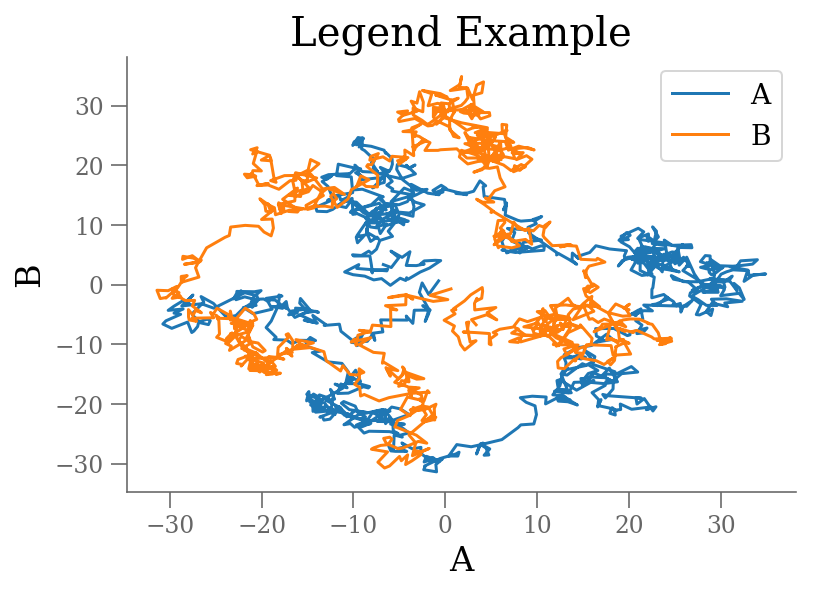

In [7]:
p = ezdata.Plotter(random_df)
p.plot('A', 'B', label='A')
p.plot('B', 'A', label='B')
plt.xlabel('A')
plt.ylabel('B')
plt.legend(loc='best')
plt.title('Legend Example');

Going further, one may want to plot all variables from a data frame against one. This is achieved below using `Plotter.all_against` method. (note that in this context, matplotlib handles dates, but we need to make the pandas index visible as a normal column)

/Users/fouesneau/anaconda/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


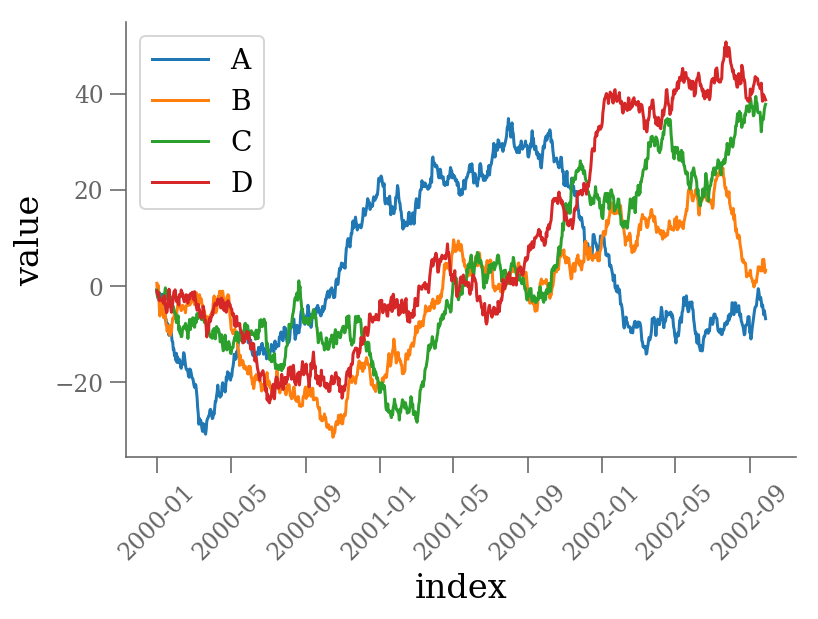

In [8]:
ezdata.Plotter(random_df.reset_index())\
      .all_against('index')\
      .plot('index', 'value')
plt.setp(plt.gca().xaxis.get_ticklabels(), rotation=45)
plt.legend()

One may want to separate the different variables into subplots. Here is how this can be done:

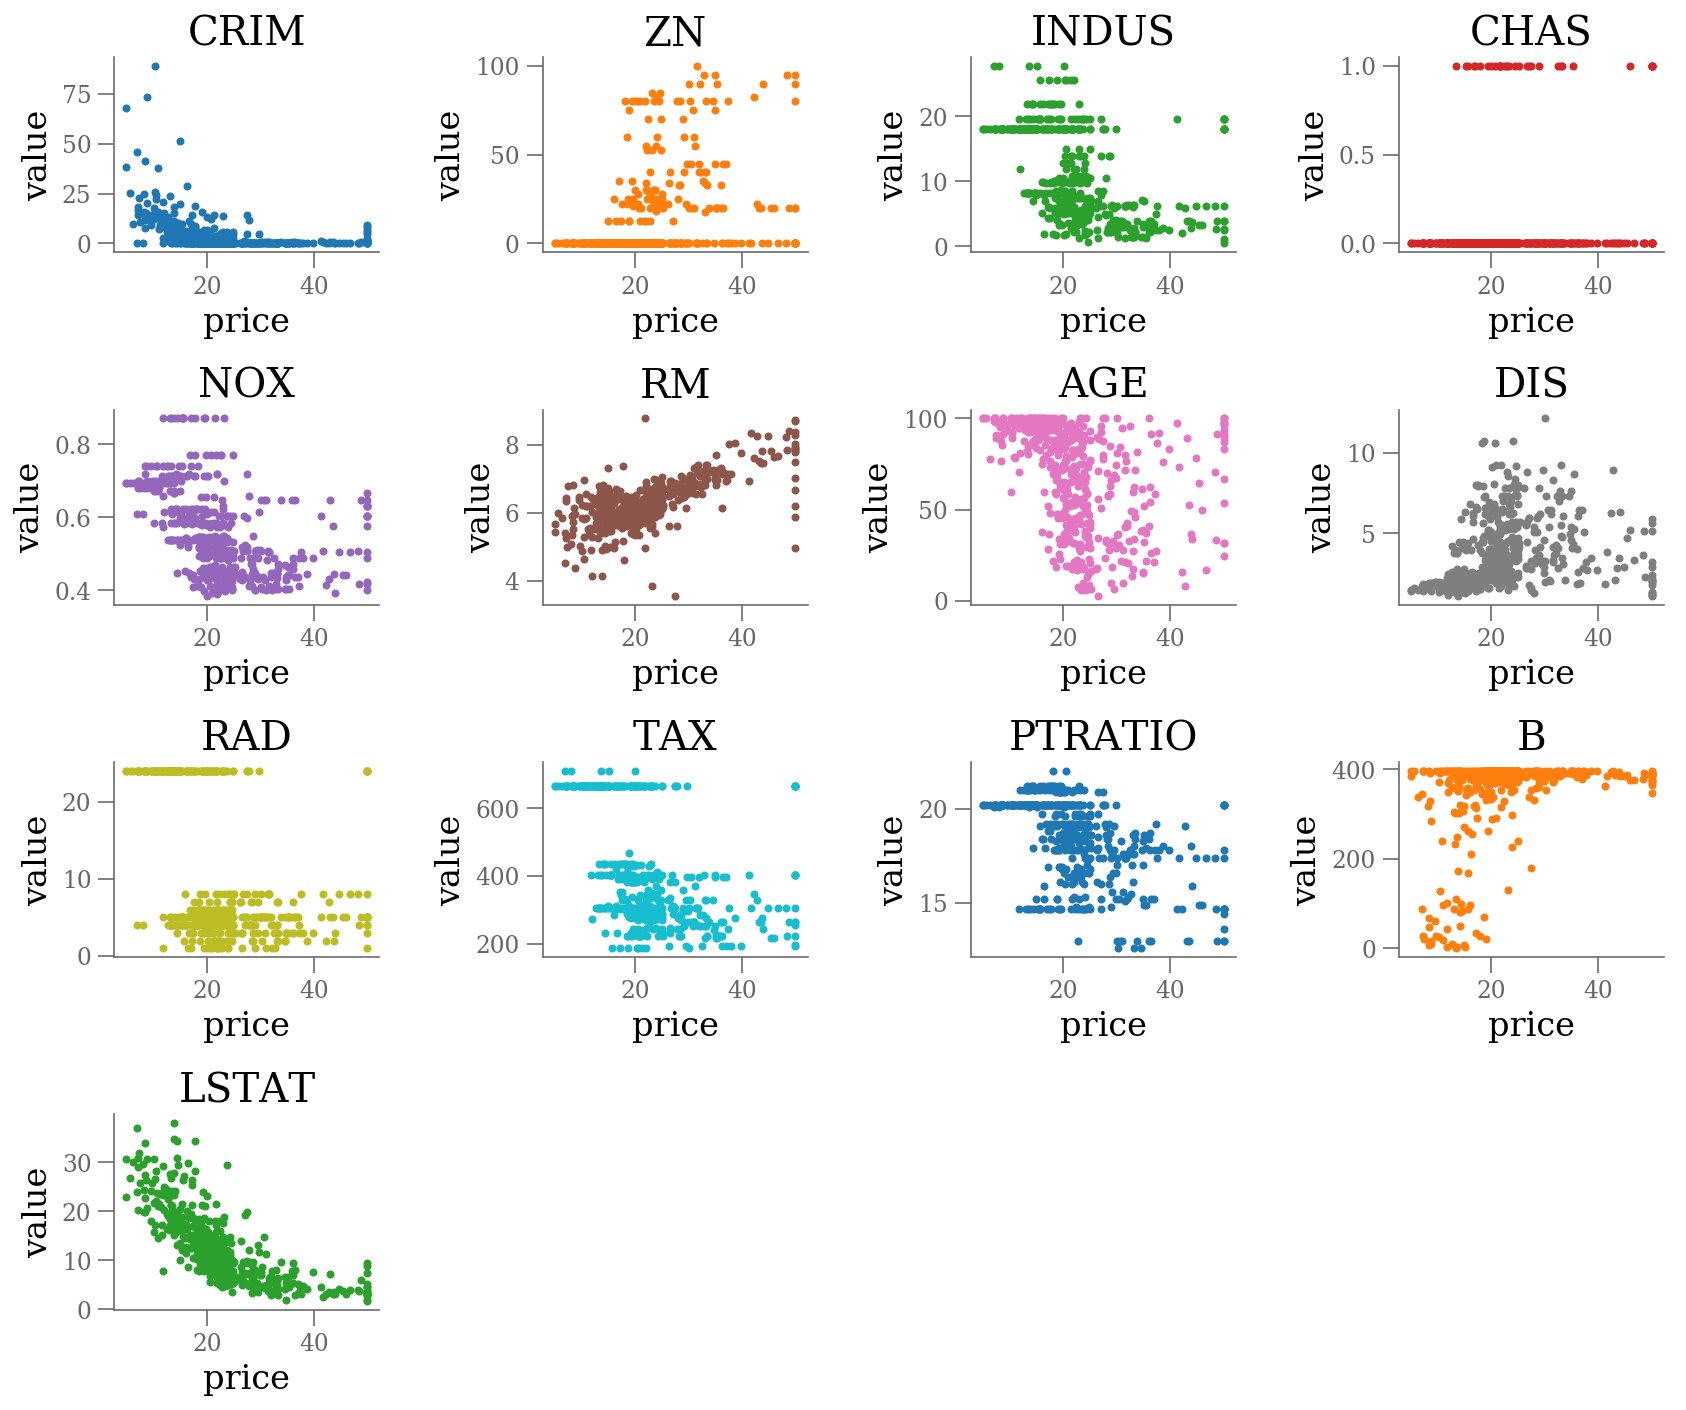

In [9]:
plt.figure(figsize=(12, 10))
boston_df.Plotter.all_against('price', facet=True, ncols=4).plot('price', 'value', '.')
plt.tight_layout()

Below we extract an image from the air dataset and play with the `ezdata.matplotlib` features: `label_subplots()` and `norm.HistEq`.

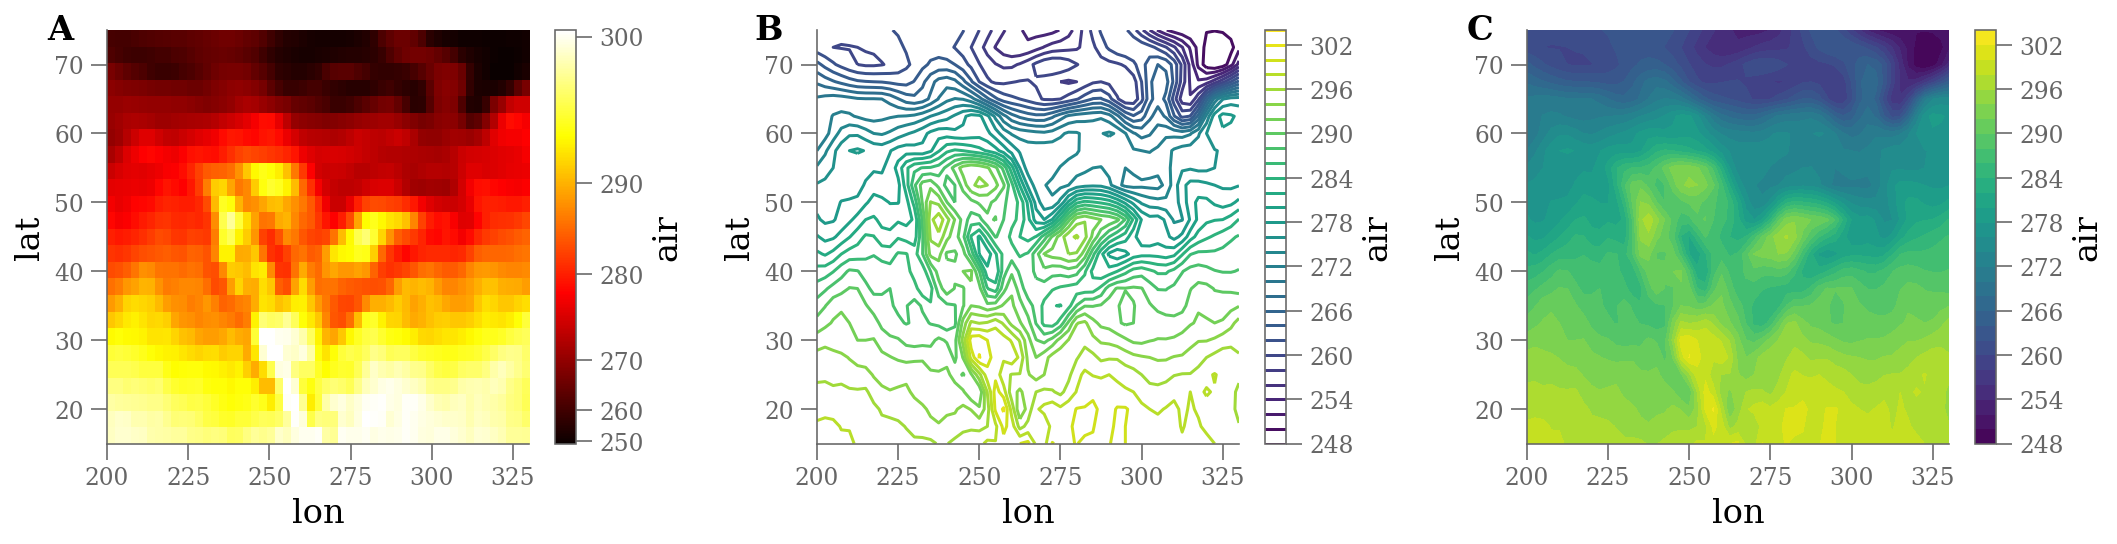

In [10]:
from ezdata.matplotlib import label_subplots, norm as mplnorm

plt.figure(figsize=(15, 4))
air2d = air.isel(time=500)
image = air2d.to_masked_array()[::-1]

plt.subplot(131)
plt.imshow(image, cmap=plt.cm.hot, 
           extent=[air2d.lon.min(), air2d.lon.max(), air2d.lat.min(), air2d.lat.max()],
           origin='lower',norm=mplnorm.HistEq(image)
           )
plt.xlabel('lon')
plt.ylabel('lat')
plt.colorbar().set_label('air')

plt.subplot(132)
plt.contour(image, levels=30, cmap=plt.cm.viridis, 
            extent=[air2d.lon.min(), air2d.lon.max(), air2d.lat.min(), air2d.lat.max()],
           )
plt.xlabel('lon')
plt.ylabel('lat')
plt.colorbar().set_label('air')

plt.subplot(133)
plt.contourf(image, levels=30, cmap=plt.cm.viridis, 
             extent=[air2d.lon.min(), air2d.lon.max(), air2d.lat.min(), air2d.lat.max()],
             )
plt.xlabel('lon')
plt.ylabel('lat')
plt.colorbar().set_label('air')

label_subplots()

plt.tight_layout()

axes = plt.gcf().get_axes()

## Plotting with Datashader

One piece that matplotlib is really bad at dealing with is the superposition of data or offering fast ways to plot density of points. This is where `datashader` excels!

`ezData.datashader.DSPlotter` is experimental and needs to be called explicitly. It is basically a normal `Plotter` but using `datashader` behind the scenes.

Note that it exploits `ezData.datashader.DSArtist`, which is an extension to what matplotlib uses to display images. This in particular offers interactive features like zooming and moving around.

In [11]:
from ezdata.datashader import DSPlotter

Have you ever tried to plot many lines while trying to represent the density of them? `Datashader` can do it, and `DSPlotter` offers it as a normal plot.

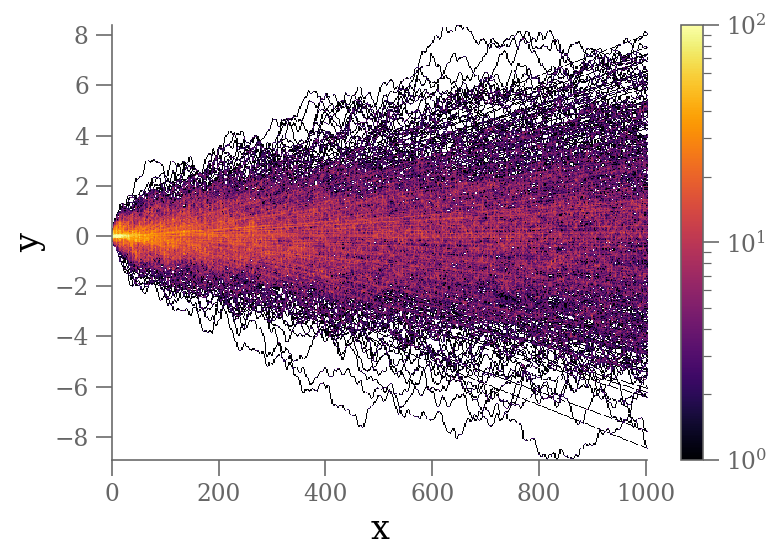

In [12]:
from matplotlib import colors
aa = DSPlotter(rd_df).line('x', 'y', cmap='inferno', vmax=100, norm=colors.LogNorm())
plt.colorbar(aa);

Let's plot the Boston housing features against the house price. 
We do as above with the addition of some optional arguments related to images.

Note in particular that `datashader` plots pixels, i.e., infinitly small dots. 
However, it also offers to spread pixels over multiple neighbors. This is also reproduced here with the `spread` keyword.

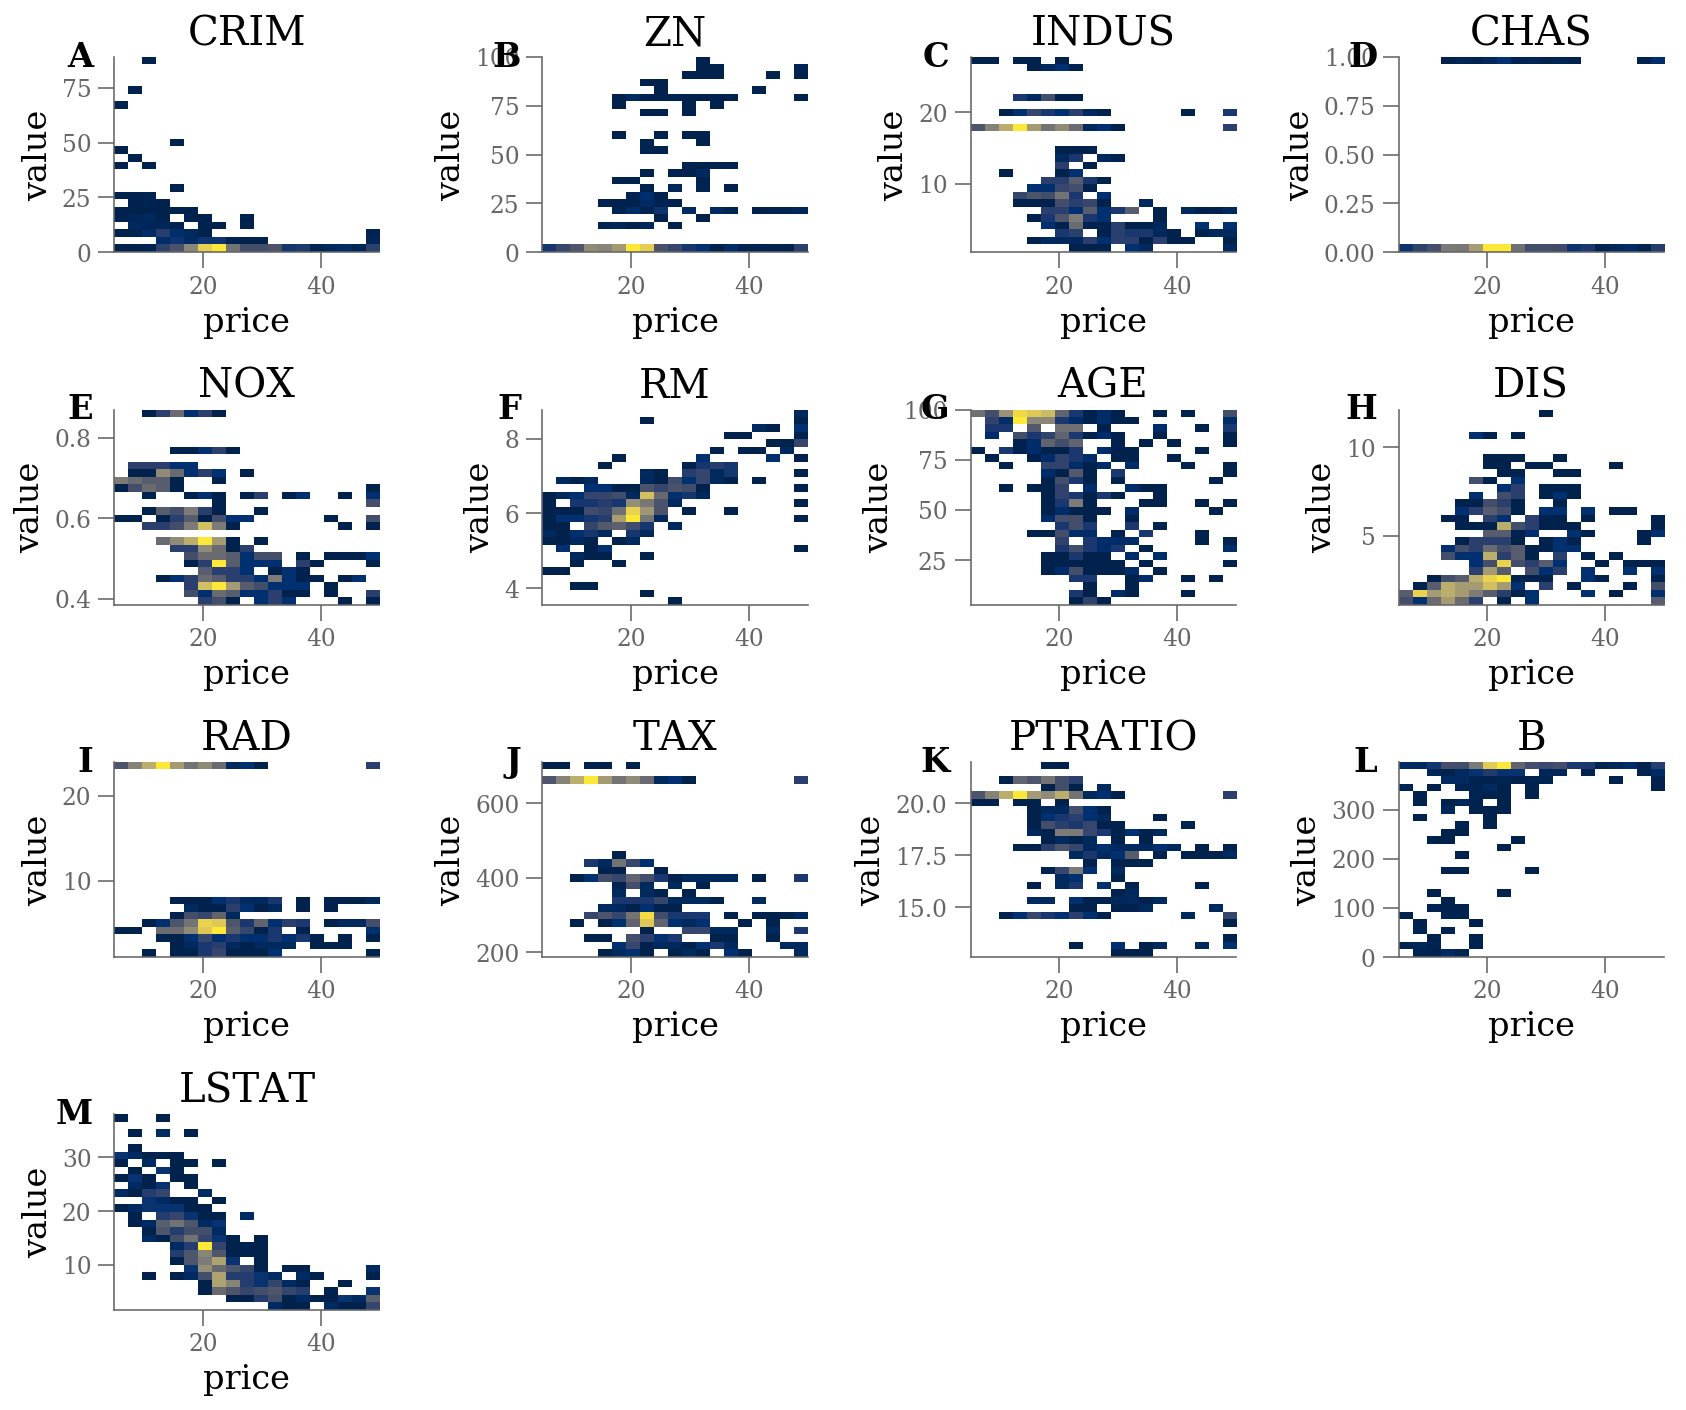

In [13]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(12, 10))
DSPlotter(boston_df)\
    .all_against('price', facet=True, ncols=4)\
    .apply('points', 'price', 'value', cmap='cividis', 
           spread=10, alpha_below=0)

label_subplots()
plt.tight_layout()

## Additional plots

Finally, I often find myself doing the "corner" plot. This is available as a "one-liner" using the `Plotter.cornerplot` method.

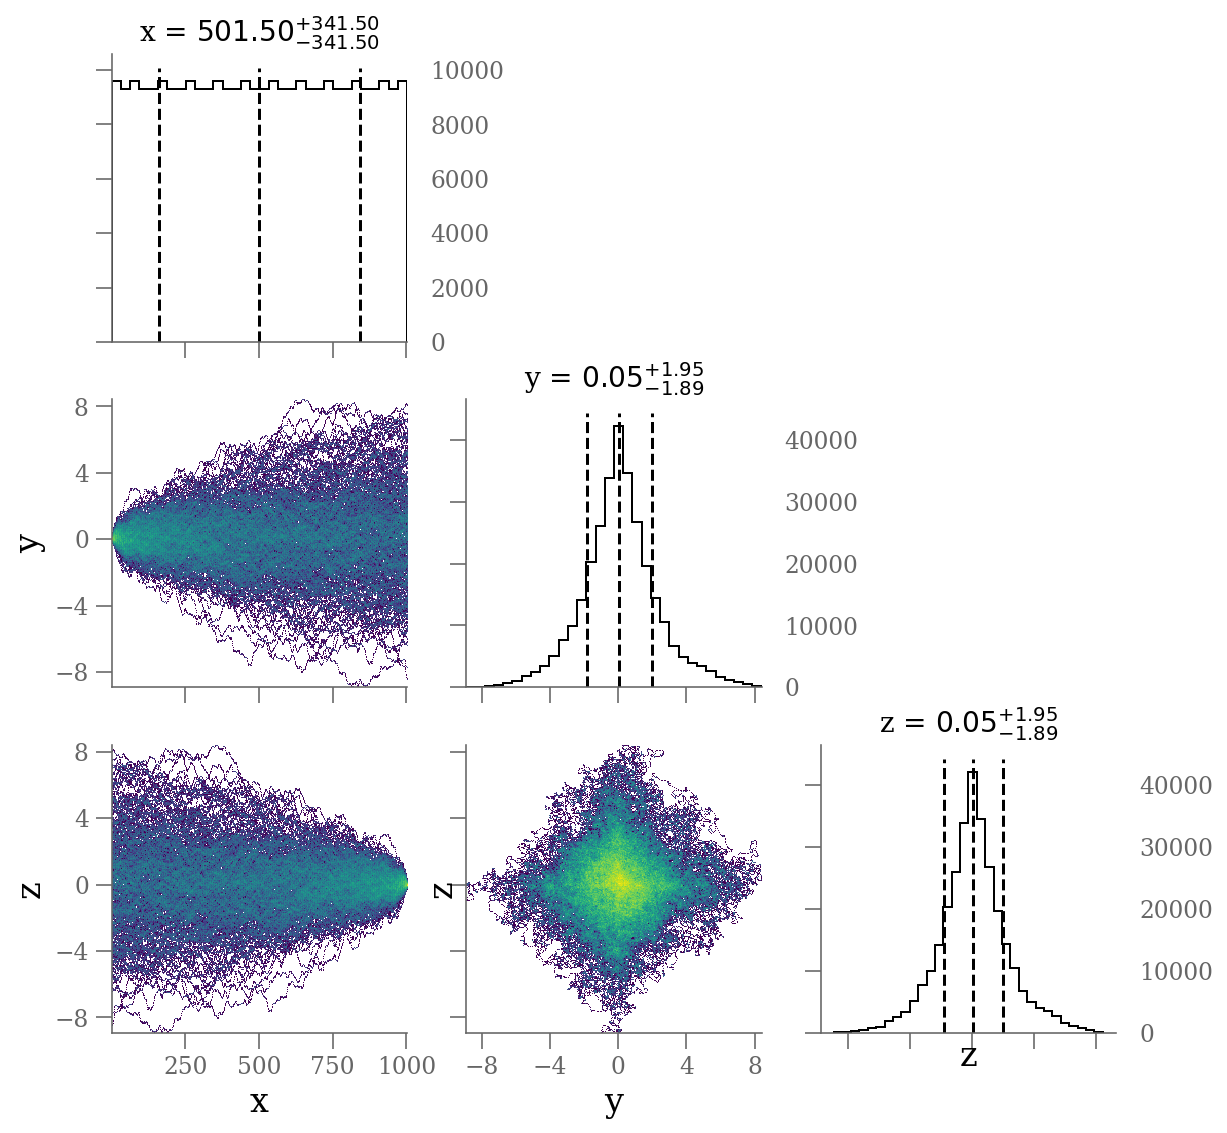

In [14]:
(DSPlotter(rd_df).cornerplot()
                # What you want to put on the diagonal (default is hist)
                .diag()          
                # Could even add the quantiles
                .add_quantiles()
                # What you want to put under it (upper for the other size)
                .lower('points', norm=colors.LogNorm())
);